# 8.1

In [3]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
def whiten(X):
    X_mean = X.mean(axis=-1)
    X -= X_mean[:, np.newaxis]
    u, d, _ = np.linalg.svd(X, full_matrices=False)
    K = (u / d).T
    X1 = np.dot(K, X)
    X1 *= np.sqrt(X.shape[1])
    return X1, K

def w_update(weights, x, eta, l):
    n_sources, n_samples = x.shape
    block = int(np.floor(np.sqrt(n_samples / 3)))
    permute_index = np.random.permutation(n_samples)
    for start,stop in [(i*block,(i+1)*block) for i in range(int(n_samples/block))]+[(int(n_samples/block)*block,n_samples)]:
        block = stop-start
        unmixed = np.dot(weights, x[:, permute_index[start:stop]])
        logf = 1 - (2 / (1 + np.exp(-unmixed)))
        weights = weights + eta * np.dot(block * np.eye(n_sources) + np.dot(logf, unmixed.T), weights)   
    return weights, l*eta

def infomax(x):

    n_sources = x.shape[0]
    weights = np.random.uniform(0,1,(n_sources,n_sources))
    old_weights = np.copy(weights)
    d_weigths = np.zeros(n_sources)
    eta = 0.0001
    l = 0.97
    epsilon = 10e-12
    change = 1
    step = 1
    
    while step < 500 and change > epsilon:

        (weights, eta) = w_update(weights, x, eta, l)

        d_weigths = weights - old_weights
        change = np.linalg.norm(d_weigths)**2
        old_weights = np.copy(weights)

        if change < epsilon:
            print("Converged at step %d: learningrate %.1e, Wchange %.1e," % (step, eta, change))
            return (np.linalg.inv(weights), np.dot(weights, x), weights)

        step = step + 1
    print('Didnt converge.')
    return (np.linalg.inv(weights), np.dot(weights, x), weights)

def buildcorrelations(N, s, x):
    p = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            #print("i: "+str(i)+" j: "+str(j)+" corr:\n"+str((np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))))
            p[i, j] = (np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))[0,1]
    return p

def myplot(W, W2, n, x, s):    
    #retrieve shats - ^s
    shatb_decentered = np.dot(W, x)
    shatb_decentered2 = np.dot(W2, x)
    N = s.shape[0]
    #Check correlations, to check whcih source goes to which output channel
    mixcors = buildcorrelations(N, s, x)
    naturalcors = buildcorrelations(N, shatb_decentered, s)
    isflippedmixes = (mixcors[0,0] < mixcors[0,1]) and (mixcors[1,0] > mixcors[1,1])
    isflippednatural = (naturalcors[0,0] < naturalcors[0,1]) and (naturalcors[1,0] > naturalcors[1,1])

    ys = [(s, 'Original Sources', False), 
          (x, 'Mixed Sources', False), 
          (n, 'Whitened Mixes', False),
          (shatb_decentered, 'FastICA with logcosh', isflippednatural),
         (shatb_decentered2, 'FastICA with cube', isflippednatural)]
    
    ylimits = [-14,14]
    f, axarr = plt.subplots(len(ys), len(s))
    f.set_size_inches(5*len(s), len(ys)*5, forward=False) 
       
    for r in range(len(ys)):
        axarr[r, 0].set_ylabel(ys[r][1])
        for i in range(len(s)):
            axarr[r, i].plot(range(ys[r][0].shape[1]), ys[r][0][i])
            axarr[r, i].set_title("Source %d"%(i+1))

            
    plt.show()

# Original

In [40]:
#Generate three signals as row vectors
t = np.arange(0,50,0.05)
s1 = 4*np.sin(t-3)
s2 = (t+5)%10
s3 = np.array([-14 if np.cos(2*ti)>0 else 0 for ti in t])
s = np.array([s1,s2,s3])

#Mix the signals to get x = As
A = np.array([[2,-3,-4],[7,5,1],[-4,7,5]])
mixed = np.dot(A,s)

#Whiten and separate the mixed
whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

#Repeat the same analysis using a different contrast function G.
ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='cube')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

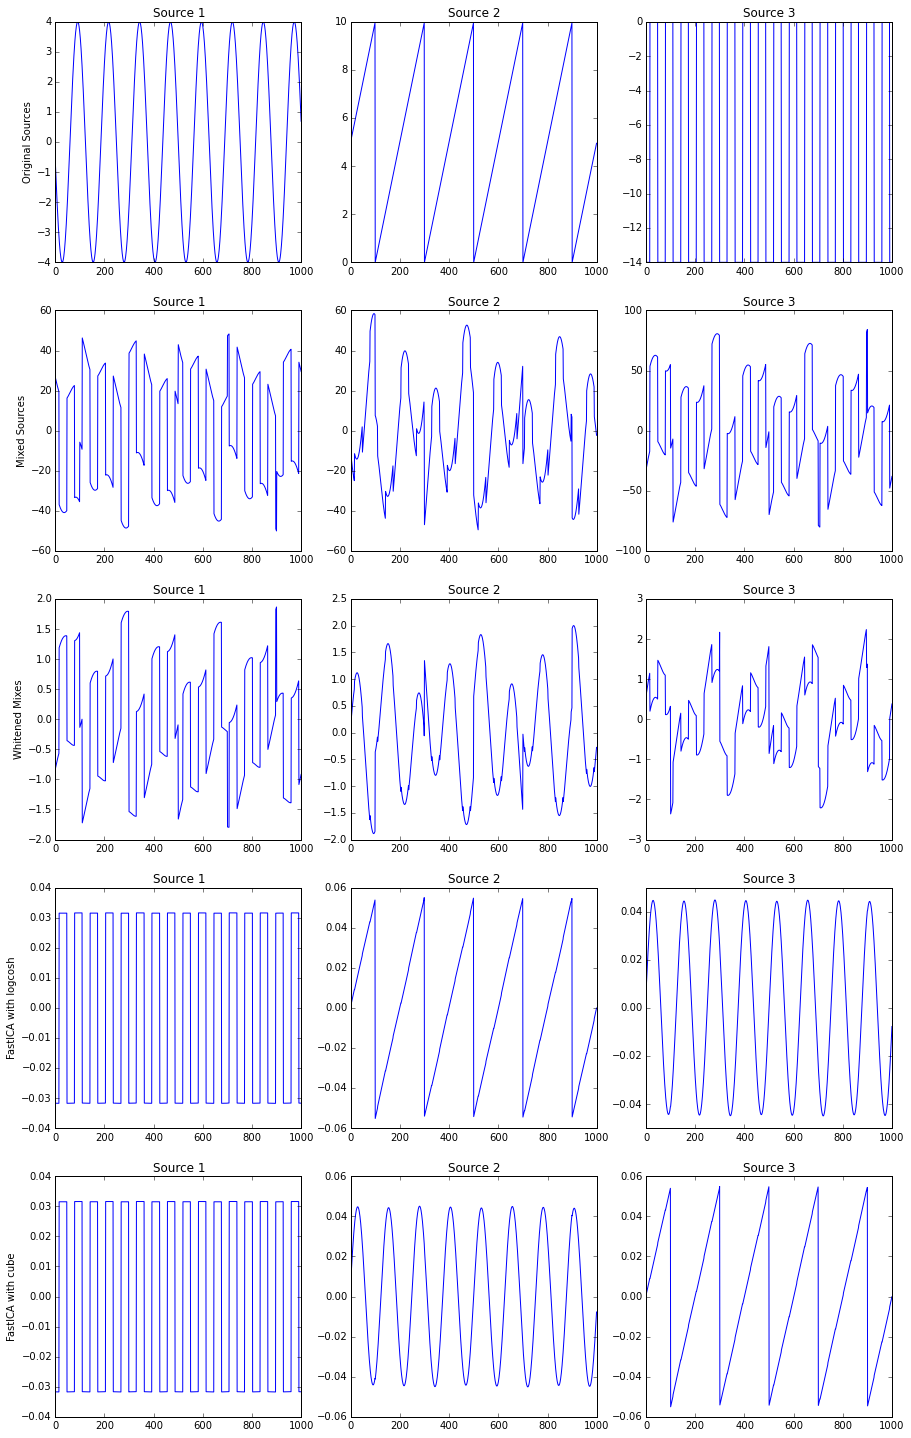

In [41]:
#Plot the original source signals, mixtures, whitened mixtures, and unmixed signals.
#Repeat the same analysis using a different contrast function G.
myplot(W, W2, whitened, mixed, s)

# Close to singular

In [42]:
#RepeatthesameanalysisusingamatrixAwhichisclosertosingularthanthematrixabove
A = np.array([[0.999999999999992,1,1],[1,0.999999999999992,1],[1,1,0.999999999999992]])
mixed = np.dot(A,s)

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='exp')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

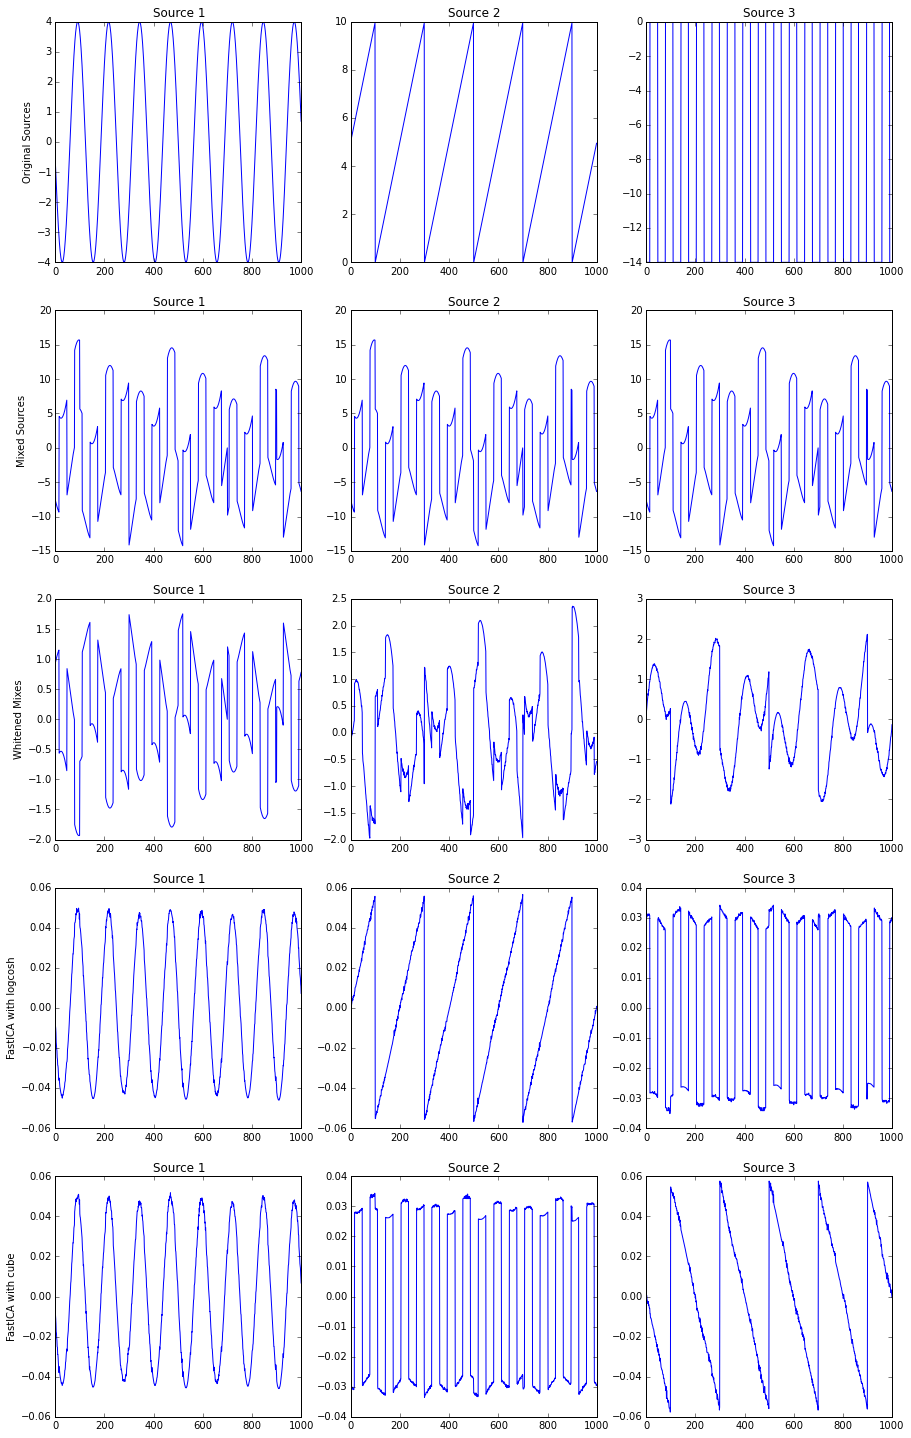

In [43]:
myplot(W, W2, whitened, mixed, s)

# Try different variances of n

In [44]:
#Repeat the same analysis using an additive zero-mean Gaussian noise n on top of the mixture
A = np.array([[2,-3,-4],[7,5,1],[-4,7,5]])
mixed = np.dot(A,s)
max_diff = mixed.max()-mixed.min()
n = np.random.normal(0,0.0001*max_diff,mixed.shape[1])
mixed = mixed + n

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='cube')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

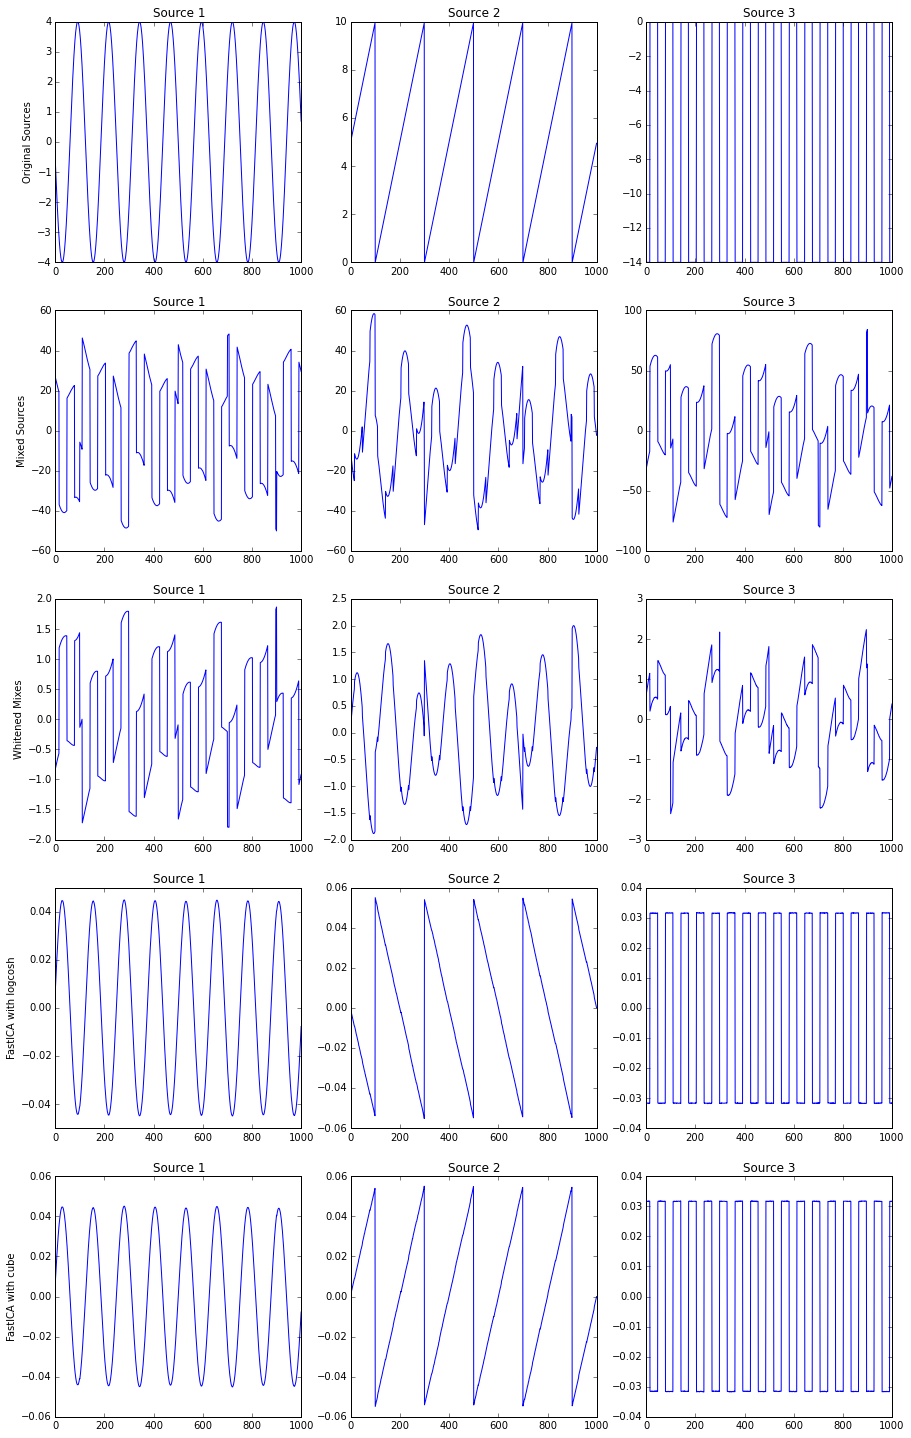

In [45]:
myplot(W, W2, whitened, mixed, s)

In [46]:
#Almost no noise
A = np.array([[2,-3,-4],[7,5,1],[-4,7,5]])

mixed = np.dot(A,s)
max_diff = mixed.max()-mixed.min()
n = np.random.normal(0,0.001*max_diff,mixed.shape[1])
mixed = mixed + n

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='cube')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

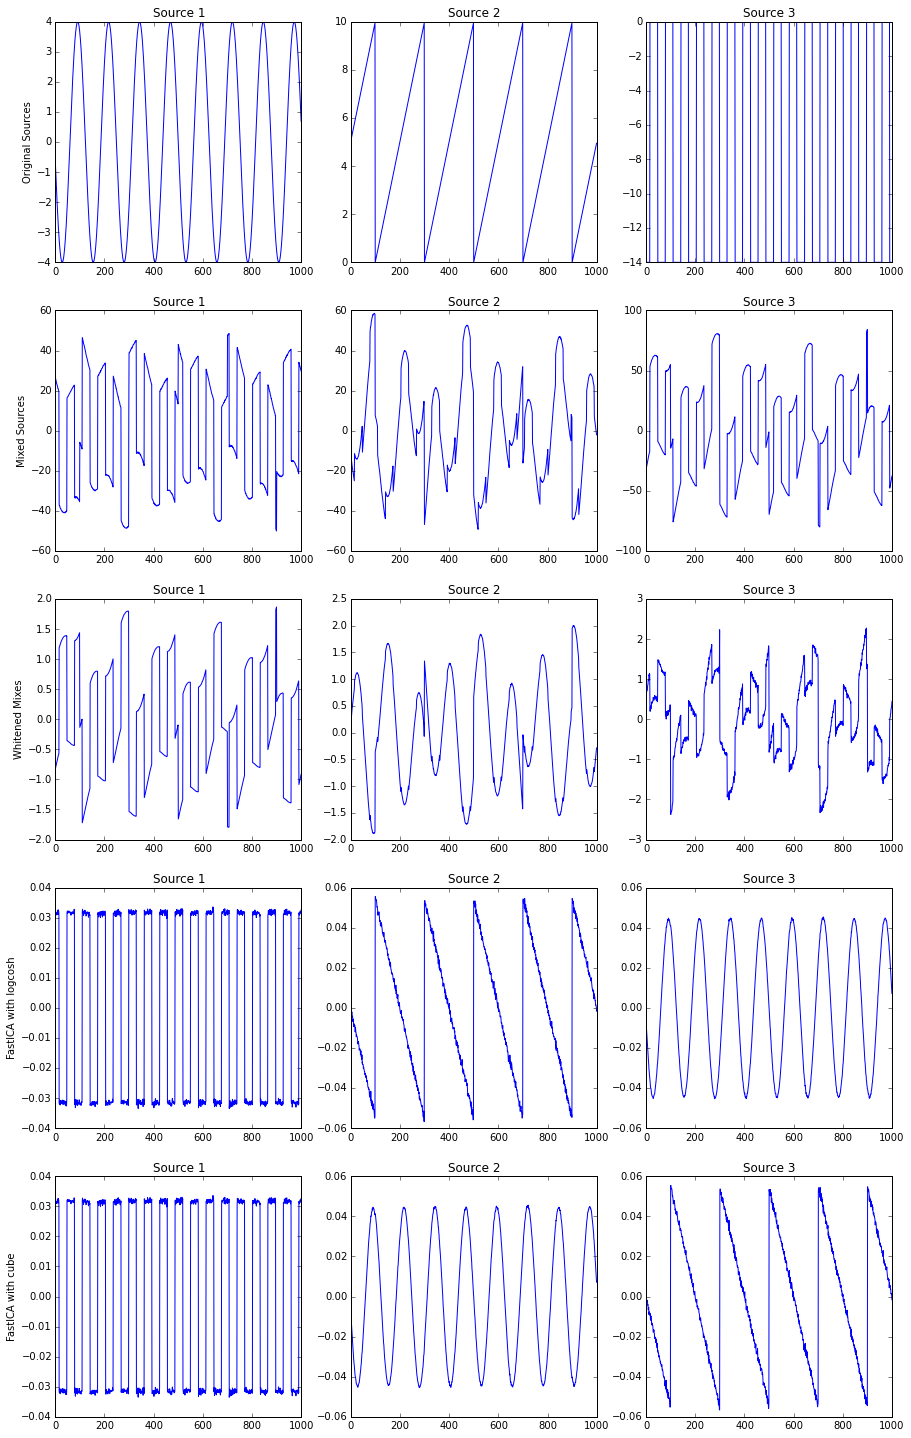

In [47]:
myplot(W, W2, whitened, mixed, s)

In [48]:
#Medium noise
A = np.array([[2,-3,-4],[7,5,1],[-4,7,5]])

mixed = np.dot(A,s)
max_diff = mixed.max()-mixed.min()
n = np.random.normal(0,0.01*max_diff,mixed.shape)
mixed = mixed + n

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='cube')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

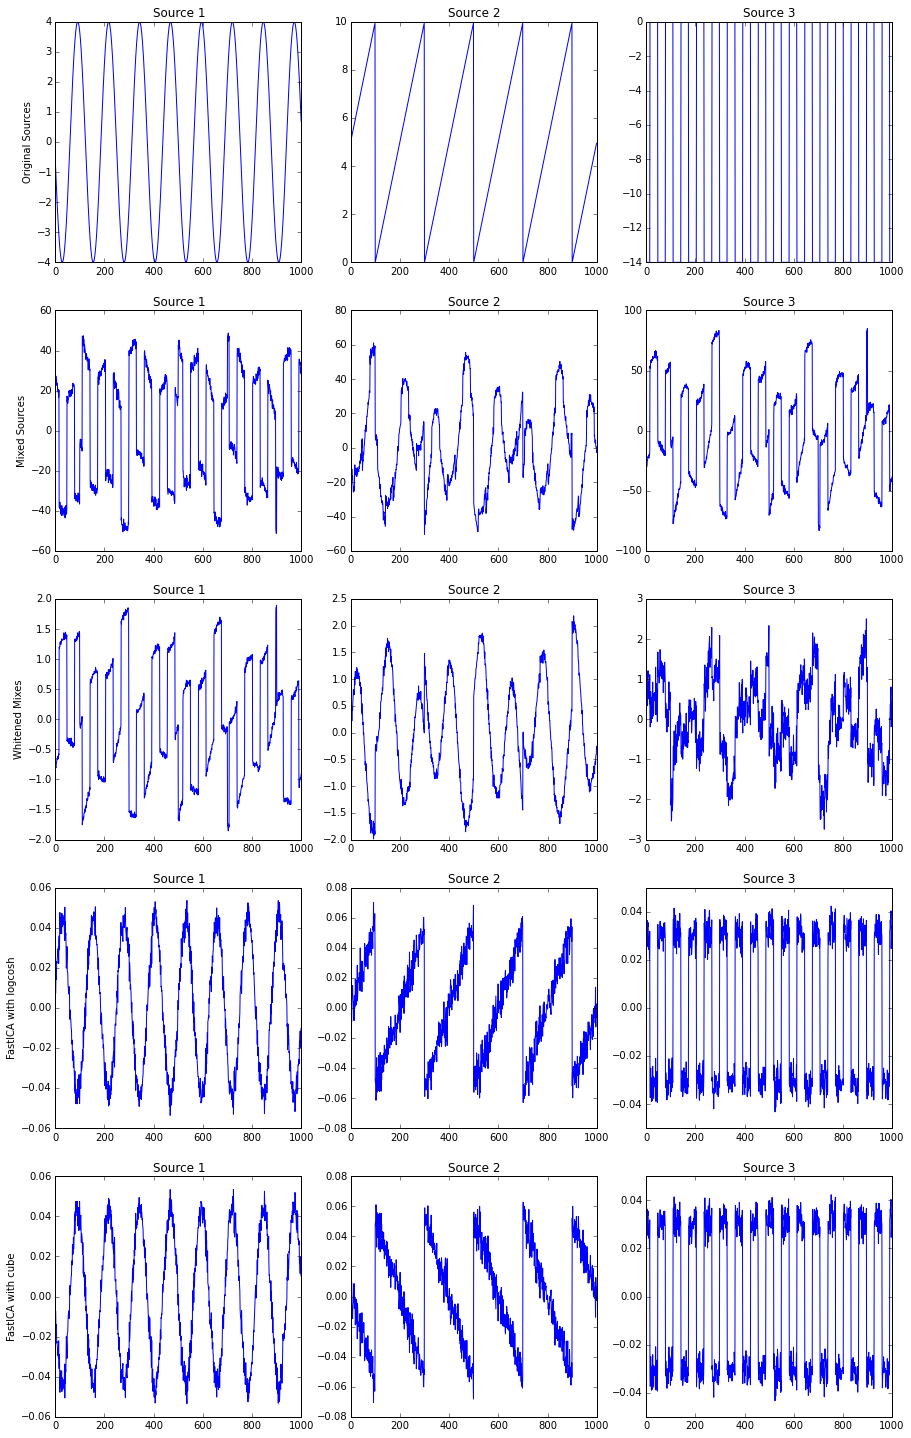

In [49]:
myplot(W, W2, whitened, mixed, s)

In [50]:
#Lots of noise
A = np.array([[2,-3,-4],[7,5,1],[-4,7,5]])

mixed = np.dot(A,s)
max_diff = mixed.max()-mixed.min()
n = np.random.normal(0,0.1*max_diff,mixed.shape)
mixed = mixed + n

whitened, K = whiten(mixed)

ica = FastICA(whiten=False, max_iter=1000, tol=0.00001)
ica.fit(whitened.T)
W = ica.components_
W = np.dot(W, K)

ica2 = FastICA(whiten=False, max_iter=1000, tol=0.00001, fun='cube')
ica2.fit(whitened.T)
W2 = ica2.components_
W2 = np.dot(W2, K)

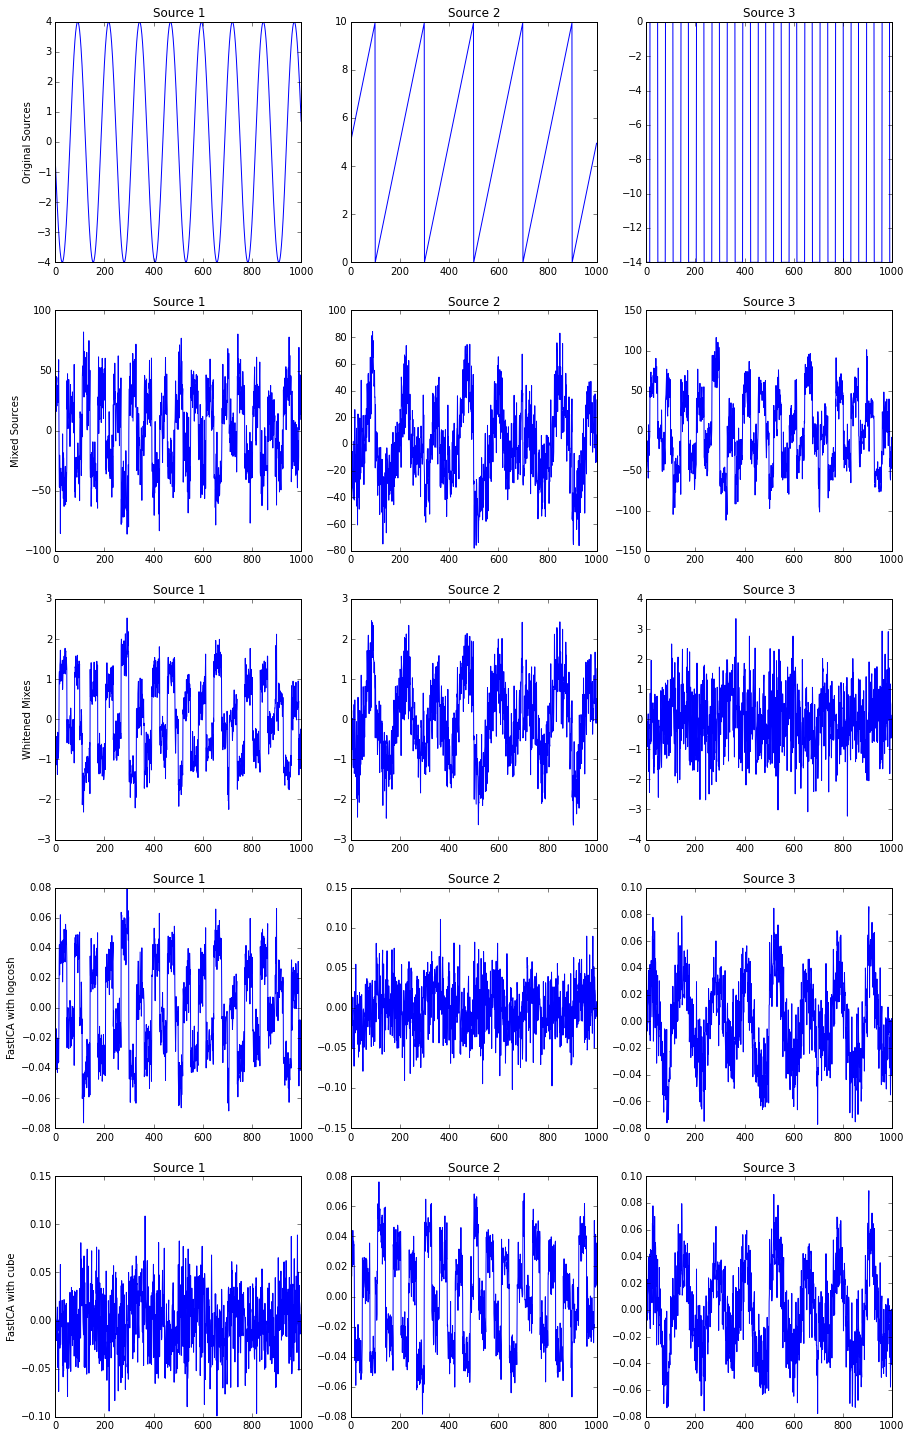

In [51]:
myplot(W, W2, whitened, mixed, s)

# 8.2

In [2]:
from sklearn.decomposition import fastica
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat as loadmat
% matplotlib inline

In [3]:
#Setup
s1 = np.loadtxt("sounds/sound1.dat")
s2 = np.loadtxt("sounds/sound2.dat")
s3 = np.random.normal(0, 1, len(s1))
s = np.array([s1, s2])

N = s.shape[0]

In [4]:
#Natural Gradient ICA
def w_update(weights, x, eta, l):
    n_samples = x.shape[1]
    n_sources = x.shape[0]
    #Malte's batch size
    block = int(np.floor(np.sqrt(n_samples / 3)))
    permute_index = np.random.permutation(n_samples)
    
    for start,stop in [(i*block,(i+1)*block) for i in range(int(n_samples/block))]+[(int(n_samples/block)*block,n_samples)]:
        block = stop-start
        
        unmixed = np.dot(weights, x[:, permute_index[start:stop]])
        #fhatp / fhatpp
        logf = 1 - (2 / (1 + np.exp(-unmixed)))
        #weight update
        weights = weights + eta/block * np.dot(block * np.eye(n_sources) + np.dot(logf, unmixed.T), weights)
        #for i in range(n_sources):
        #    weights[i,i] = 1
    return weights, np.power(l,block)*eta

def batchinfomax(x):

    n_sources = x.shape[0]
    weights = np.random.uniform(0,1,(n_sources,n_sources))
    old_weights = np.copy(weights)
    d_weigths = np.zeros(n_sources)
    eta = 0.01
    #eta = 2./x.shape[1]
    l = 0.9999
    #epsilon = 10e-12
    epsilon = eta/1000.
    change = 1
    step = 1
    
    while step < 500 and change > epsilon:

        (weights, eta) = w_update(weights, x, eta, l)

        d_weigths = weights - old_weights
        change = np.linalg.norm(d_weigths)**2
        old_weights = np.copy(weights)

        if change < epsilon:
            print("Converged at step %d: learningrate %.1e, Wchange %.1e, Relative change %.1e" % (step, eta, change, np.sum(d_weigths)/np.sum(weights)))
            return (np.linalg.inv(weights), np.dot(weights, x), weights)

        step = step + 1
    print('Didn\'t converge.')
    return (np.linalg.inv(weights), np.dot(weights, x), weights)

def fhat(y):
    return 1 / (1 + np.exp(-y))
def fhatpp_fhatp(y):
    return 1 - 2*fhat(y)

def  dWnatural(eta, W, x):
    Wx = np.dot(W, x.reshape(-1,1))
    return eta * np.dot((np.eye(W.shape[0]) + np.dot(fhatpp_fhatp(Wx), Wx.T)), W)

def onlineinfomax(xc):
    eta = .01
    l = .9999
    epsilon = .000001
    Wn = np.random.uniform(0, 1, (x.shape[0], x.shape[0]))
    Wnbs = np.random.uniform(0, 1, (x.shape[0], x.shape[0]))
    nConverged = False
    nbsConverged = False
    
    for T in range(1000):
        permute_index = np.random.permutation(xc.shape[1])
        xcp = xc[:,permute_index]
        for t in range(xcp.shape[1]):
            Tt = T*xcp.shape[1]+t
            xa = xcp[:,t]
            
            #Natural
            if not nConverged:
                dWn = dWnatural(eta*(np.power(l, Tt)), Wn, xa)
                if np.sum(np.power(dWn,2)) > epsilon:
                    Wn = Wn + dWn
                else:
                    nConverged = True
                    print("n converged at "+str(Tt))
            
            #Natural with Bell-Sejnowski regularization
            if not nbsConverged:
                dWnbs = dWnatural(eta*(np.power(l,Tt)), Wnbs, xa)
                if np.sum(np.power(dWnbs,2)) > epsilon:
                    Wnbs = Wnbs + dWnbs
                    for n in range(N):
                        Wnbs[n, n] = 1
                else:
                    nbsConverged = True
                    print("nbs converged at "+str(Tt))
            
            if nConverged and nbsConverged:
                break
            
            if Tt%4000 == 0:
                #print(str( Tt )+" - "+str(np.sum(np.power(dWn,2)))+" "+str(np.sum(np.power(dWnbs,2))))
                pass
            
        if nConverged and nbsConverged:
            break
            
    return Wn, Wnbs



def buildcorrelations(N, s, x):
    p = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            #print("i: "+str(i)+" j: "+str(j)+" corr:\n"+str((np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))))
            p[i, j] = (np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))[0,1]
    return p


def myplot(Ws, xs, titles):
    nsources = Ws[0].shape[0]
    
    #Things to plot
    ys = []
    for i in range(len(Ws)):
        #retrieve shats - ^s
        ys.append((np.dot(Ws[i], xs[i]), titles[i]))
    
    #ylimits = [-14,14]
    f, axarr = plt.subplots(len(ys), nsources)
    f.set_size_inches(2*5*nsources, len(ys)*5, forward=False) 
    
    #Set some great titles
    for S in range(nsources):
        axarr[0, S].set_title("Source "+str(S))
    
    #Plots
    for r in range(len(ys)):
        axarr[r, 0].set_ylabel(ys[r][1])
        for i in range(nsources):
            axarr[r, i].plot(range(ys[r][0].shape[1]), ys[r][0][i], color="seagreen")

            
    plt.show()

# Random mixing matrix

Didn't converge.
nbs converged at 31802
n converged at 75539


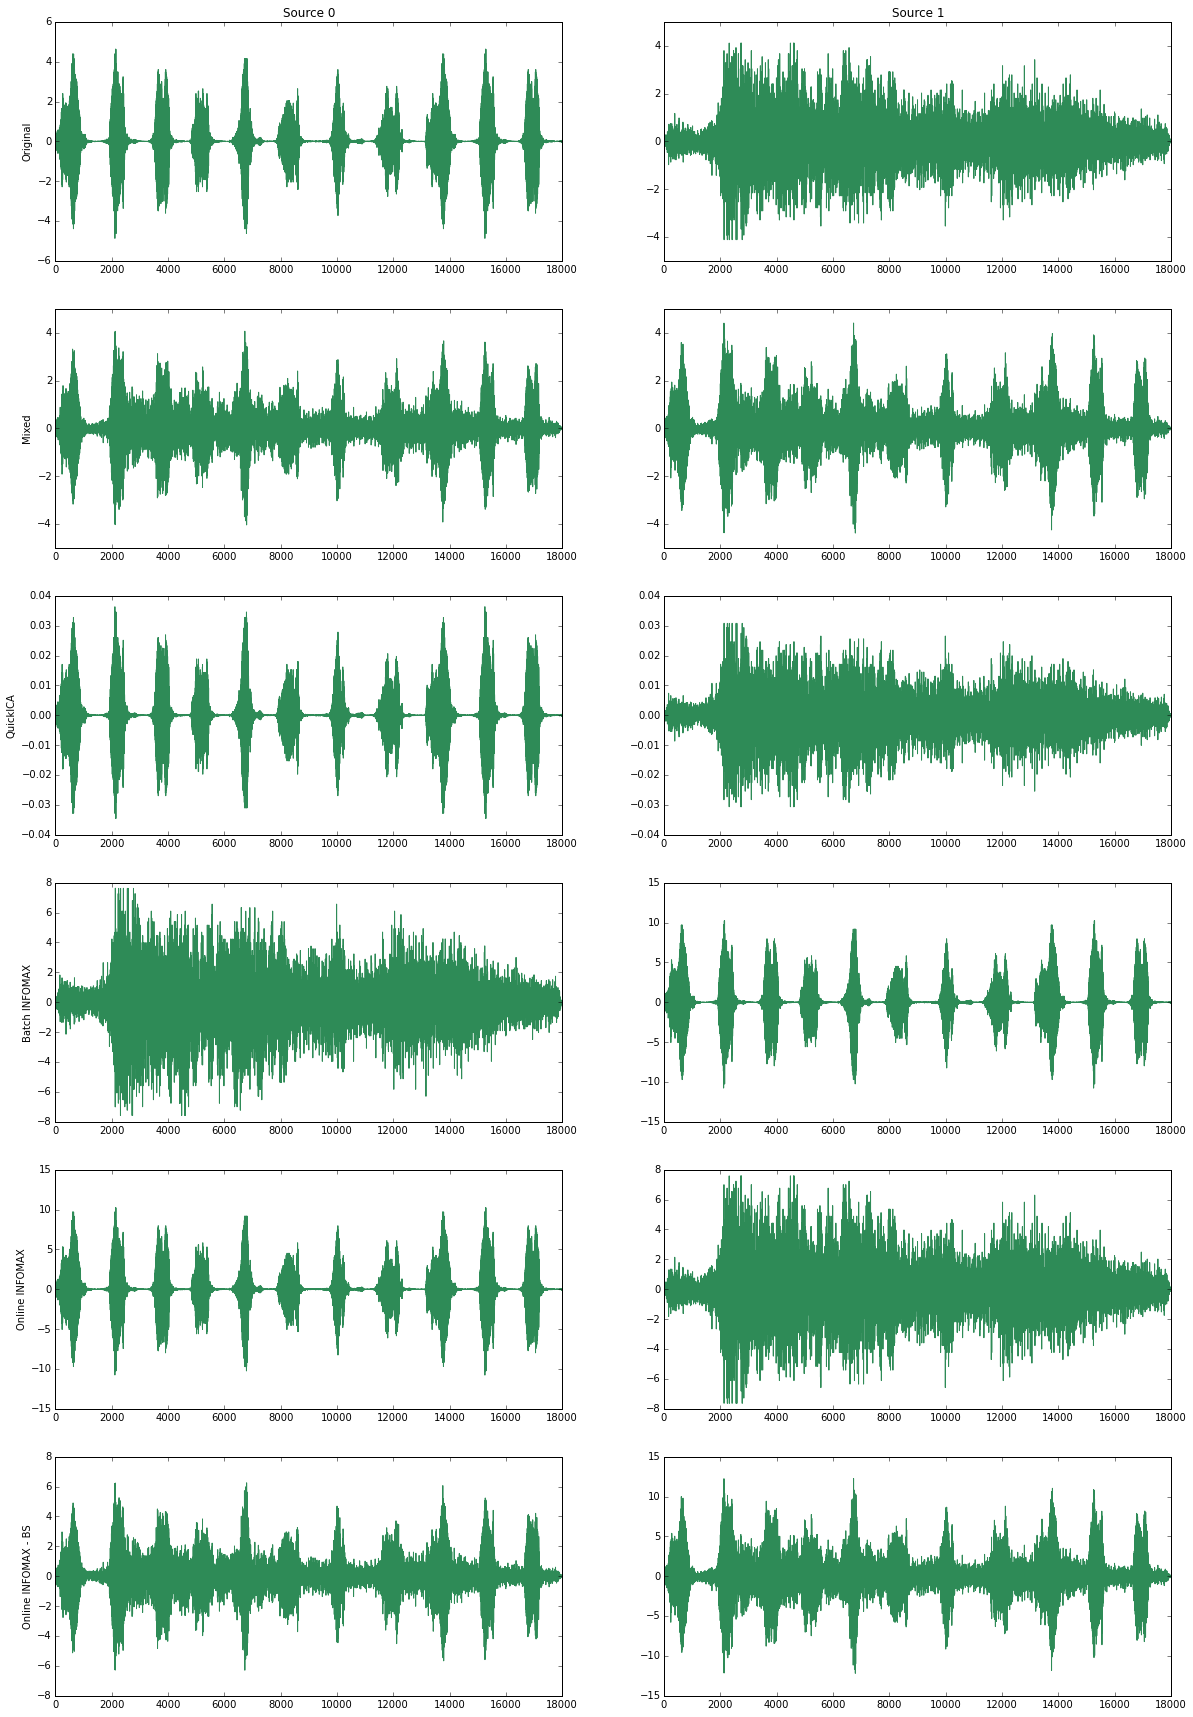

In [5]:
A = np.random.uniform(0, 1, (N, N))

x = np.dot(A, s)
x_mean = np.mean(x, axis = 1).reshape(-1,1)
x -= x_mean


#Quick ICA
ica = FastICA(max_iter=500)
ica.fit(x.T)  # Reconstruct signals
#shat = ica.fit_transform(x)  # Reconstruct signals
#A_ = ica.mixing_  # Get estimated mixing matrix
Wq = ica.components_

#Batch Infomax
Ahat , _, Wi = batchinfomax(x)

#Online Infomax
Wn, Wnbs = onlineinfomax(x)

myplot(
    [np.eye(s.shape[0]), np.eye(s.shape[0]), Wq, Wi, Wn, Wnbs], 
    [s, x, x, x, x, x], 
    ["Original", "Mixed", "QuickICA", "Batch INFOMAX", "Online INFOMAX", "Online INFOMAX - BS"]
)

# Close to singular mixing matricies

Converged at step 261: learningrate 2.1e-03, Wchange 5.7e-07, Relative change -2.8e-04
nbs converged at 27836
n converged at 29094
Didn't converge.
n converged at 2
nbs converged at 36459
Didn't converge.
nbs converged at 28721
n converged at 349656


/Users/henri/anaconda/lib/python3.4/site-packages/sklearn/decomposition/fastica_.py:117: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


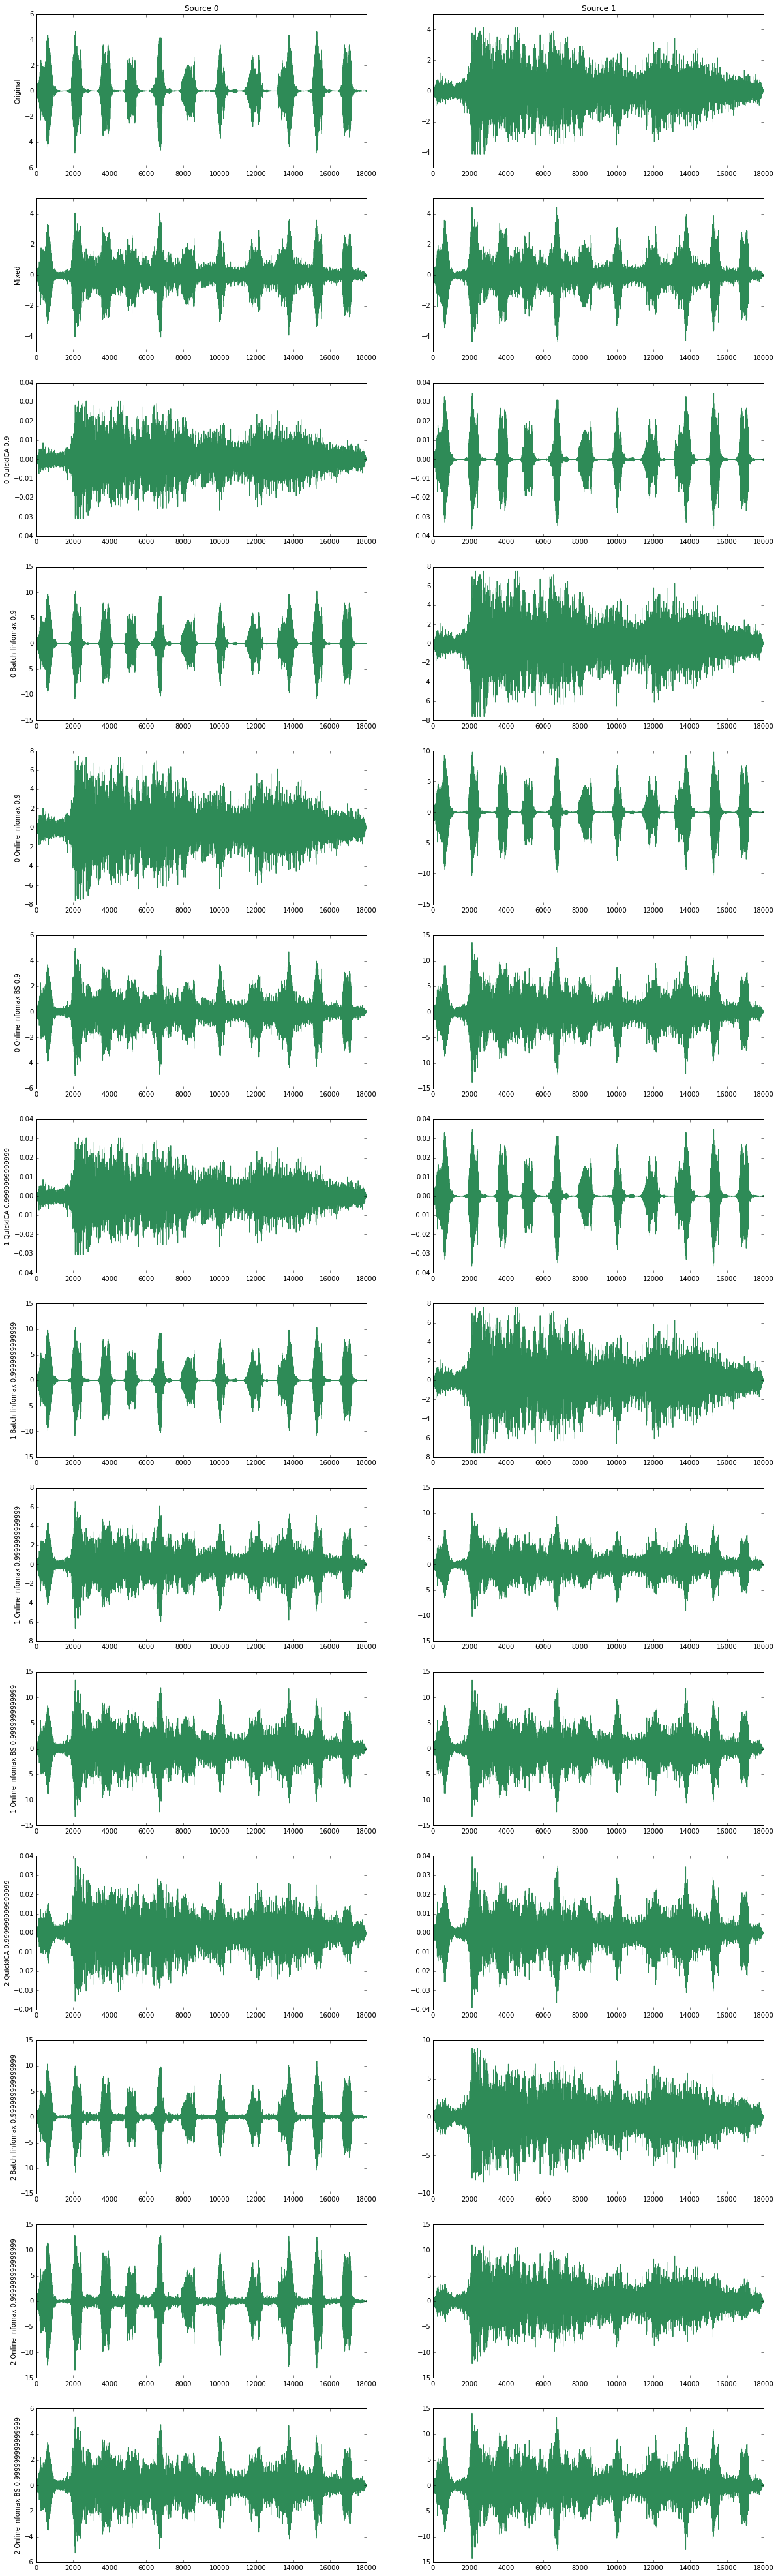

In [7]:
Ws = [np.eye(s.shape[0]), np.eye(s.shape[0])]
xs = [s, x]
titles = ["Original", "Mixed"]
for I, i in enumerate([.9, .9999999999999, .999999999999999]):
    A = np.ones( (s.shape[0], s.shape[0]) )
    for d in range(s.shape[0]):
        A[d,d] = i
    
    #
    xi = np.dot(A, s)
    xi_mean = np.mean(xi, axis = 1).reshape(-1,1)
    xi -= xi_mean

    #Quick ICA
    ica = FastICA(max_iter=500)
    ica.fit(xi.T)  # Reconstruct signals
    Wq = ica.components_
    
    #Infomax - batch
    Ahat , _, Wi = batchinfomax(xi)
    
    #Infomax - online
    Wn, Wnbs = onlineinfomax(xi)
    
    Ws += [Wq.copy(), Wi.copy(), Wn.copy(), Wnbs.copy()]
    xs += [xi.copy(), xi.copy(), xi.copy(), xi.copy()]
    titles += [str(I)+" QuickICA "+str(i), str(I)+" Batch Iinfomax "+str(i), str(I)+" Online Infomax "+str(i), str(I)+" Online Infomax BS "+str(i)]
myplot(Ws, xs, titles)

# Time of convergence

In [22]:
#Setup
A = np.random.uniform(0, 1, (N, N))

x = np.dot(A, s)
x_mean = np.mean(x, axis = 1).reshape(-1,1)
x -= x_mean

In [23]:
def qicatime():
    #Quick ICA
    ica = FastICA(max_iter=500)
    ica.fit(x.T)  # Reconstruct signals
    Wq = ica.components_
%timeit qicatime()

100 loops, best of 3: 4.07 ms per loop


In [26]:
#Batch Infomax
%timeit Ahat , _, Wi = batchinfomax(x)

Converged at step 250: learningrate 2.3e-03, Wchange 7.2e-06, Relative change 3.1e-04
Converged at step 261: learningrate 2.1e-03, Wchange 7.0e-06, Relative change -1.2e-03
Converged at step 244: learningrate 2.4e-03, Wchange 2.5e-06, Relative change -9.1e-04
Converged at step 153: learningrate 4.1e-03, Wchange 8.1e-06, Relative change -9.3e-04
1 loops, best of 3: 1.25 s per loop


In [28]:
#Online Infomax
%timeit Wn, Wnbs = onlineinfomax(x)

n converged at 29005
n converged at 29073
n converged at 30170
n converged at 29686
1 loops, best of 3: 740 ms per loop


# 8.3

In [8]:
# inline in the notebook
%matplotlib inline
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA
import os
from PIL import Image
import matplotlib.cm as cm

# Load Images

In [9]:
# (a)

imagesn = []
imagesb = []
imagest = []
for f in os.listdir("imgpca") :
    img = Image.open("imgpca/" + f)
    if f[0:1] == "n":
        imagesn.append(img.copy())
    if f[0:1] == "b":
        imagesb.append(img.copy())
    if f[0:1] == "t":
        imagest.append(img.copy())


def sample(category, n, P):
    if category == "n":
        img = imagesn[np.random.randint(0, len(imagesn))]
    if category == "b":
        img = imagesb[np.random.randint(0, len(imagesb))]
    if category == "t":
        img = imagest[np.random.randint(0, len(imagest))]
        
    x = np.random.randint(0, img.size[0] - n)
    y = np.random.randint(0, img.size[1] - n)

    subimg = np.asarray(img.crop((x,y,x+n,y+n)).getdata())
    return subimg

def sampleall(n, P):
    imgsn = np.zeros((1, np.power(n,2)))
    imgsb = np.zeros((1, np.power(n,2)))
    imgst = np.zeros((1, np.power(n,2)))
    for i in range(P):
        if i % 1000 == 0:
            print(i)
        imgsn = np.vstack( (imgsn, sample("n", n, P).reshape(1,-1)) )
        imgsb = np.vstack( (imgsb, sample("b", n, P).reshape(1,-1)) )
        imgst = np.vstack( (imgst, sample("t", n, P).reshape(1,-1)) )
        
    print(P)
    
    return imgsn[1:,:], imgsb[1:,:], imgst[1:,:]



# Many Samples

In [10]:
#N_sqrt,P = (20,50000)
N_sqrt,P = (14,20000)   # use this to test
N = N_sqrt**2

imgsn, imgsb, imgst = sampleall(N_sqrt, P)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


#==============#
# ICA  Natural #
#==============#


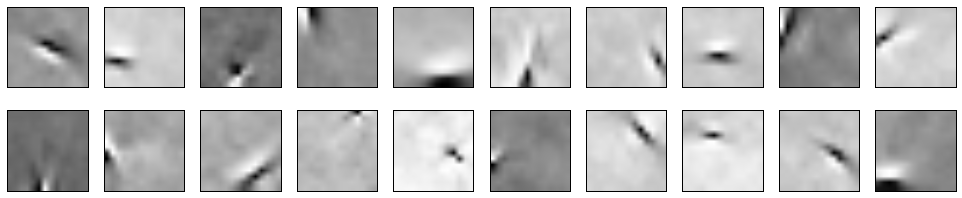

#==============#
# PCA  Natural #
#==============#


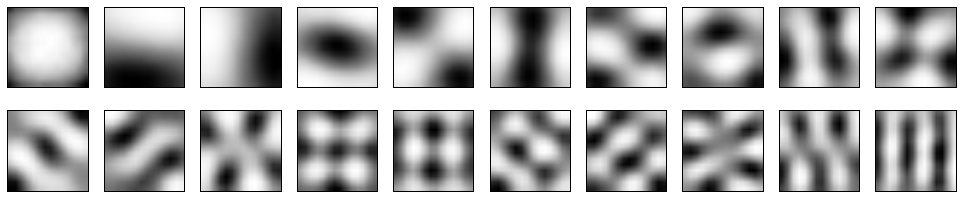

#================#
# ICA  Buildings #
#================#


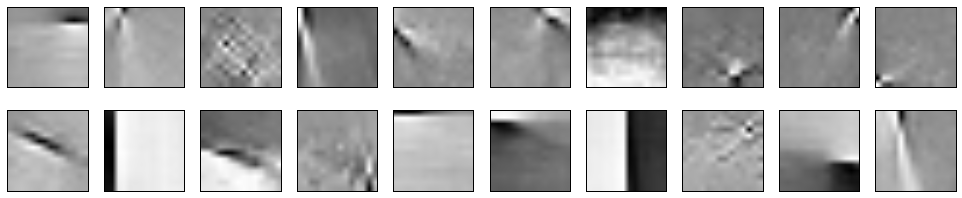

#================#
# PCA  Buildings #
#================#


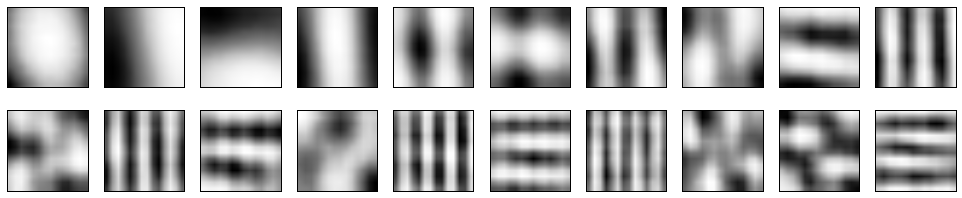

#===========#
# ICA  Text #
#===========#


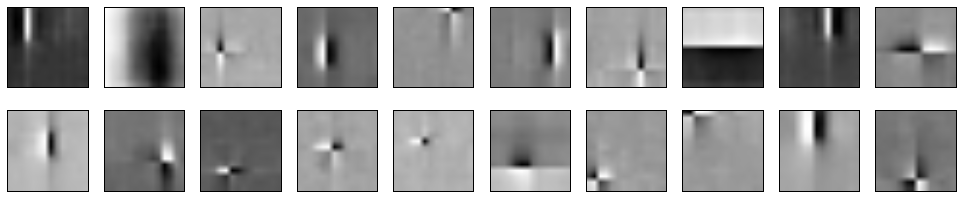

#===========#
# PCA  Text #
#===========#


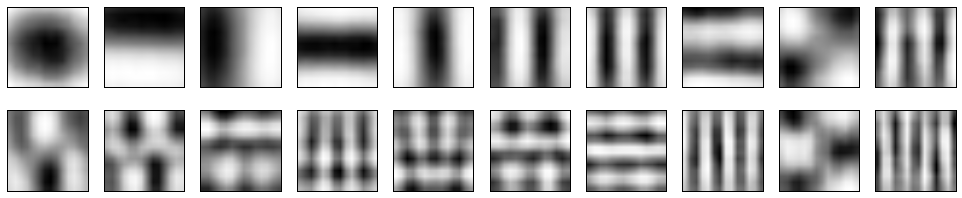

In [35]:

# (c)
numpcrows = 2
numpccols = 10

def plot_comps(A_) : 
    plt.figure(figsize=(17,3.4))
    for i in range(A_.shape[0]) :
        plt.subplot(numpcrows,numpccols,i+1)
        data = A_[i]
        data.shape = (N_sqrt, N_sqrt)
        #print(data)
        plt.imshow(data, cmap = cm.Greys_r)
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    plt.show()
    
    
# (b + d)
category = ["Natural","Buildings","Text"]
for i, imgpatches in enumerate([imgsn, imgsb, imgst]) :
    
    # G(s) = a^{-1} log cosh (as), with a = 1
    # ~> G(s) = log cosh (s)
    # default options use symmetric (called: parallel) and  log cosh as negentropy approximation
    ica = FastICA(max_iter=500,whiten=True,fun='logcosh') 
    #print(imgpatches.shape)
    ica.fit(imgpatches)
    ICA_ = ica.mixing_.T
    print ("#======={0}#".format("="*len(category[i])))
    print ("# ICA  {0} #".format(category[i]))
    print ("#======={0}#".format("="*len(category[i])))
    plot_comps(ICA_[0:numpcrows*numpccols])

    pca = PCA()
    #U, s, V = pca._fit(imgpatches)
    pca.fit(imgpatches)
    #print(U.shape) 
    #print(S.shape)
    #print(V.shape)
    
    PCA_ = pca.components_ # V
    print ("#======={0}#".format("="*len(category[i])))
    print ("# PCA  {0} #".format(category[i]))
    print ("#======={0}#".format("="*len(category[i])))
    plot_comps(PCA_[0:numpcrows*numpccols])



# Few Samples

In [37]:
N_sqrt,P = (14,2000)   # use this to test
N = N_sqrt**2

imgsnsmall, imgsbsmall, imgstsmall = sampleall(N_sqrt, P)

0
1000
2000


#==============#
# ICA  Natural #
#==============#


/Users/henri/anaconda/lib/python3.4/site-packages/sklearn/decomposition/fastica_.py:117: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


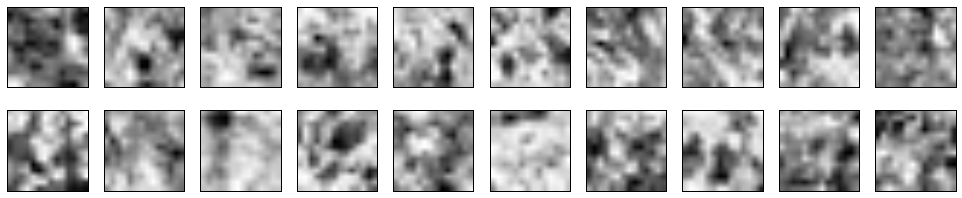

#==============#
# PCA  Natural #
#==============#


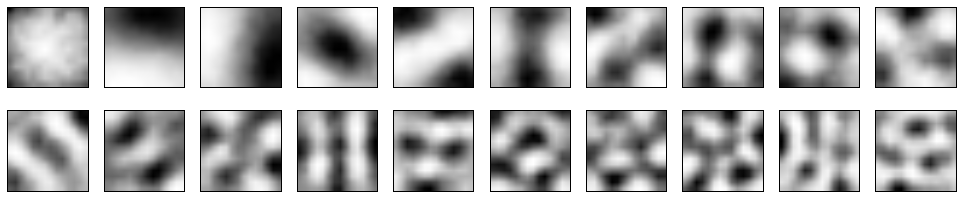

#================#
# ICA  Buildings #
#================#


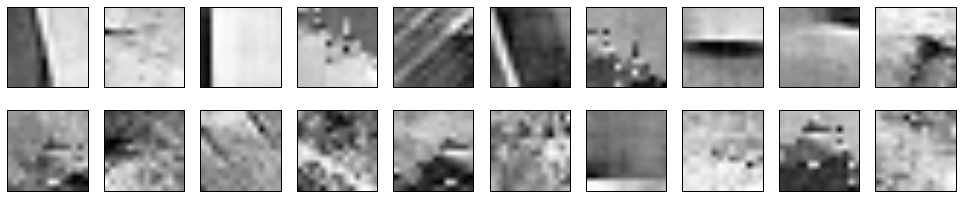

#================#
# PCA  Buildings #
#================#


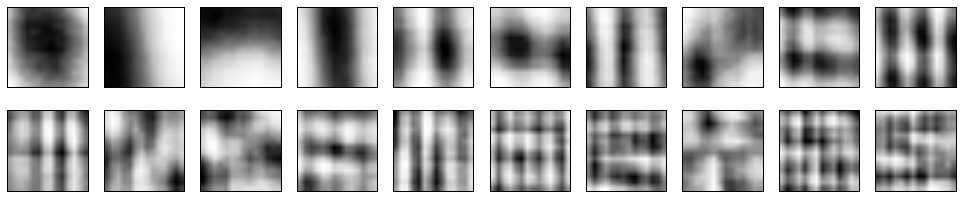

#===========#
# ICA  Text #
#===========#


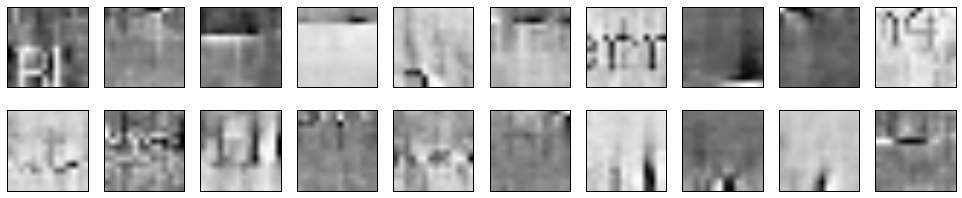

#===========#
# PCA  Text #
#===========#


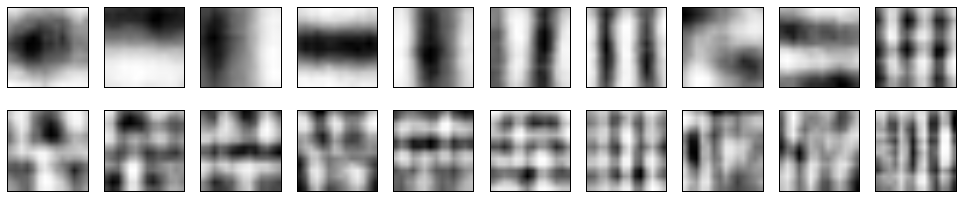

In [53]:

# (c)
numpcrows = 2
numpccols = 10

def plot_comps(A_) : 
    plt.figure(figsize=(17,3.4))
    for i in range(A_.shape[0]) :
        plt.subplot(numpcrows,numpccols,i+1)
        data = A_[i]
        data.shape = (N_sqrt, N_sqrt)
        #print(data)
        plt.imshow(data, cmap = cm.Greys_r)
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    plt.show()
    
    
# (b + d)
category = ["Natural","Buildings","Text"]
for i, imgpatches in enumerate([imgsnsmall, imgsbsmall, imgstsmall]) :
    
    # G(s) = a^{-1} log cosh (as), with a = 1
    # ~> G(s) = log cosh (s)
    # default options use symmetric (called: parallel) and  log cosh as negentropy approximation
    ica = FastICA(max_iter=900,whiten=True,fun='logcosh') 
    #print(imgpatches.shape)
    ica.fit(imgpatches)
    
    ICA_ = ica.mixing_.T
    print ("#======={0}#".format("="*len(category[i])))
    print ("# ICA  {0} #".format(category[i]))
    print ("#======={0}#".format("="*len(category[i])))
    plot_comps(ICA_[0:numpcrows*numpccols])

    pca = PCA()
    #U, s, V = pca._fit(imgpatches)
    pca.fit(imgpatches)
    #print(U.shape) 
    #print(S.shape)
    #print(V.shape)
    
    PCA_ = pca.components_ # V
    print ("#======={0}#".format("="*len(category[i])))
    print ("# PCA  {0} #".format(category[i]))
    print ("#======={0}#".format("="*len(category[i])))
    plot_comps(PCA_[0:numpcrows*numpccols])



# Transposes

#==============#
# ICA  Natural #
#==============#


/Users/henri/anaconda/lib/python3.4/site-packages/sklearn/decomposition/fastica_.py:117: UserWarning: FastICA did not converge. You might want to increase the number of iterations.
  ' to increase the number of iterations.')


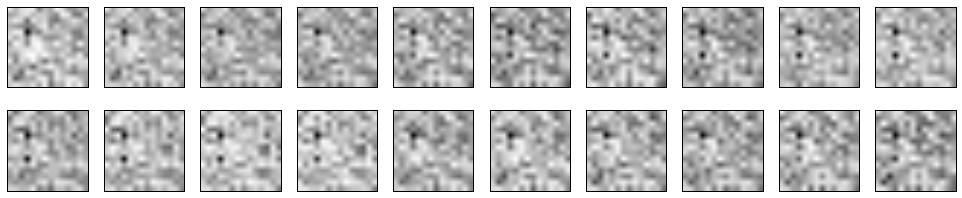

#================#
# ICA  Buildings #
#================#


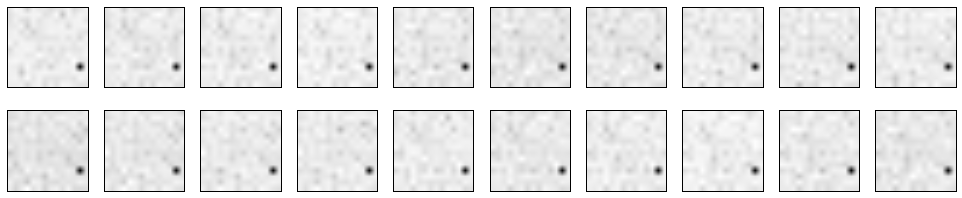

#===========#
# ICA  Text #
#===========#


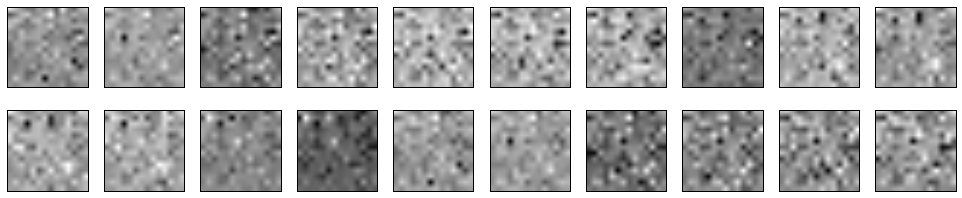

In [57]:
# (c)
numpcrows = 2
numpccols = 10

def plot_comps(A_) : 
    plt.figure(figsize=(17,3.4))
    for i in range(A_.shape[0]) :
        plt.subplot(numpcrows,numpccols,i+1)
        data = A_[i]
        data.shape = (N_sqrt, N_sqrt)
        #print(data)
        plt.imshow(data, cmap = cm.Greys_r)
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    plt.show()
    
    
# (b + d)
category = ["Natural","Buildings","Text"]
for i, imgpatches in enumerate([imgsnsmall, imgsbsmall, imgstsmall]) :
    
    # G(s) = a^{-1} log cosh (as), with a = 1
    # ~> G(s) = log cosh (s)
    # default options use symmetric (called: parallel) and  log cosh as negentropy approximation
    ica = FastICA(max_iter=900,whiten=True,fun='logcosh') 
    #print(imgpatches.shape)
    ica.fit(imgpatches)
    
    ICA_ = ica.mixing_
    print ("#======={0}#".format("="*len(category[i])))
    print ("# ICA  {0} #".format(category[i]))
    print ("#======={0}#".format("="*len(category[i])))
    plot_comps(ICA_[0:numpcrows*numpccols])

